In [1]:
%load_ext autoreload
%autoreload 2

import itertools as it
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

matplotlib.rc("axes", **{"spines.top": False, "spines.right": False})
matplotlib.rc("legend", frameon=False)

In [2]:
method_order = ["torch", "triton-bkn", "triton-bk"]

def get_method_name(s: pd.Series) -> str:
    if "triton" in s.method:
        return "triton-" + s.args["kernel"]
    return "torch"

def bandwidth(s: pd.Series) -> int:
    dtype_size = dict(float16=2)[s["dtype"]]
    # Assume indices are torch.long (8 bytes)
    bytes_per_topk = s.topk_size * dtype_size + s.k * (8 + dtype_size)
    return s.n_inner * s.batch_size * bytes_per_topk / s.duration

def io_size(s: pd.Series) -> int:
    dtype_size = dict(float16=2)[s["dtype"]]
    return (s.n_inner_inputs or s.n_inner) * s.topk_size * dtype_size + s.n_inner * s.k * (8 + dtype_size)

df = (pd.read_json("results.jsonl.gz", lines=True)
    .pipe(lambda d: d.assign(
        method=d.apply(get_method_name, axis=1),
        duration=d.duration.apply(np.mean),
        interleaved=d.args.apply(lambda s: s["interleaved"]),
        topk_ratio=d.topk_size//d.k,
        topk_size_base=d.topk_size.apply(lambda n: round(n / 128) * 128),
        topk_size_offset=d.topk_size.apply(lambda n: n - round(n / 128) * 128),
        n_inner_inputs=d.n_inner_inputs.fillna(d.n_inner),
    ))
    .pipe(lambda d: d.assign(
        bandwidth=d.apply(bandwidth, axis=1),
        io_size=d.apply(io_size, axis=1),
    ))
    [["topk_size", "topk_size_base", "topk_size_offset", "topk_ratio", "io_size", "interleaved", "method", "bandwidth"]]
)
print(len(df), "rows")
df.head()

5376 rows


,topk_size,topk_size_base,topk_size_offset,topk_ratio,io_size,interleaved,method,bandwidth
0,1023,1024,-1,2,915968.0,False,torch,1.359003e+11
1,1023,1024,-1,2,915968.0,False,triton-bk,1.165354e+11
2,1023,1024,-1,2,915968.0,False,triton-bkn,1.114316e+11
3,1024,1024,0,2,917504.0,False,torch,1.449453e+11
4,1024,1024,0,2,917504.0,False,triton-bk,1.260654e+11


## General picture (dominated by input+output size)

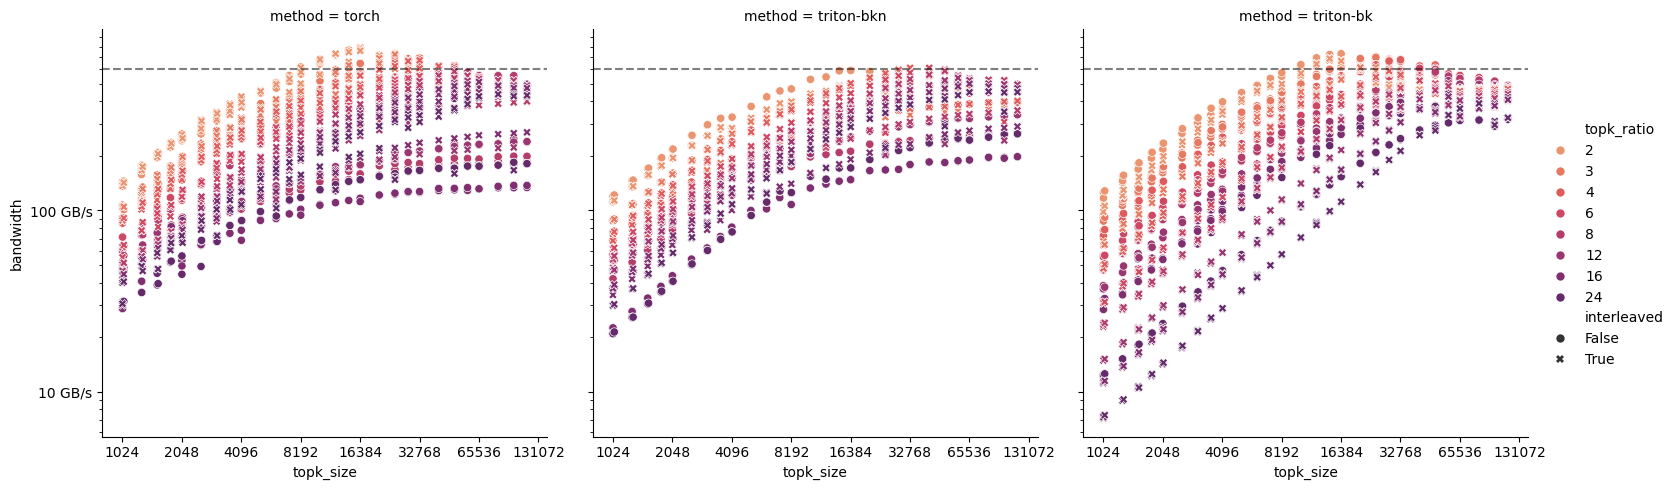

In [3]:
g = sns.relplot(data=df.pipe(lambda d: d.assign(topk_ratio=d.topk_ratio.apply(str))),
                y="bandwidth", x="topk_size", hue="topk_ratio", style="interleaved", col="method", col_order=method_order,
                palette="flare")
for ax in g.axes.flatten():
    ax.set_yscale("log")
    ax.axhline(600e9, color="k", ls="--", alpha=.5)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")

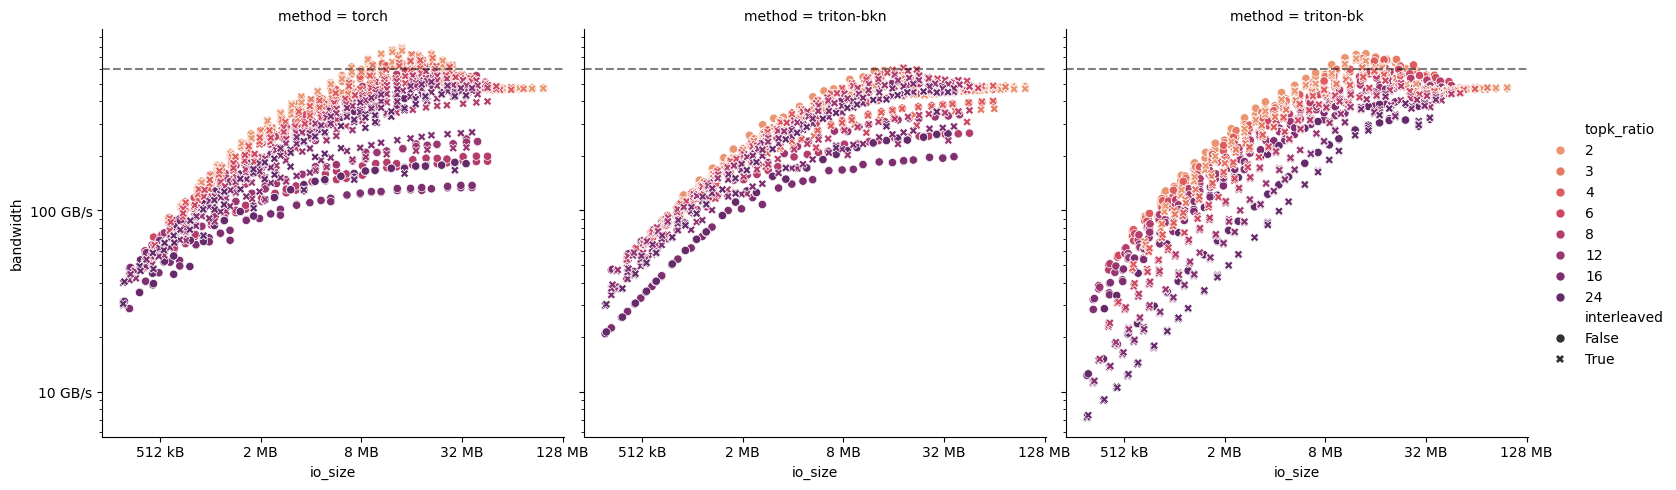

In [4]:
g = sns.relplot(data=df.pipe(lambda d: d.assign(topk_ratio=d.topk_ratio.apply(str))),
                y="bandwidth", x="io_size", hue="topk_ratio", style="interleaved", col="method", col_order=method_order,
                palette="flare")
for ax in g.axes.flatten():
    ax.set_yscale("log")
    ax.axhline(600e9, color="k", ls="--", alpha=.5)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(lambda x, _: f"{x/2**20:.0f} MB" if x >= 2**20 else f"{x/2**10:.0f} kB")
    ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")

## Specific pairs of (k/n, offset) are slow for torch/triton-bkn

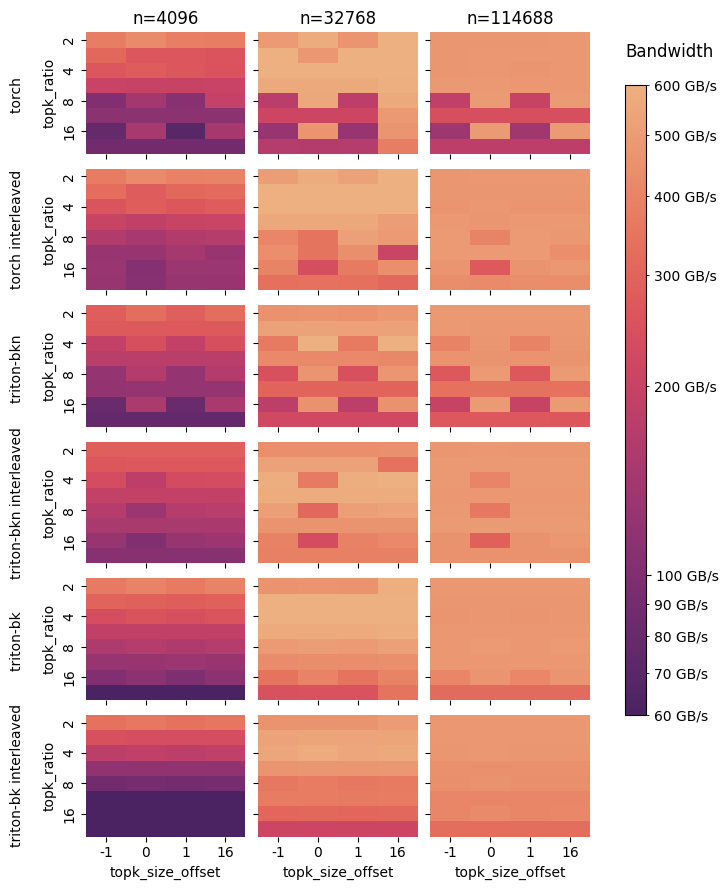

In [5]:
topk_sizes = [4096, 32768, 114688]
method_interleaved = [(m, i) for m in method_order for i in [False, True]]

fig, axs = plt.subplots(ncols=len(topk_sizes), nrows=len(method_interleaved), figsize=(1 + 2*len(topk_sizes), 1.5*len(method_interleaved)),
    sharex=True, sharey=True)

norm = matplotlib.colors.LogNorm(60e9, 600e9)
palette = "flare_r"
for r, axr, (method, interleaved) in zip(it.count(), axs, method_interleaved):
    for c, ax, topk_size in zip(it.count(), axr, topk_sizes):
        d = df[(df.method==method)&(df.interleaved==interleaved)&(df.topk_size_base == topk_size)]
        m = sns.heatmap(d.pivot(index="topk_ratio", columns="topk_size_offset", values="bandwidth"), ax=ax, norm=norm, cmap=palette, cbar=False)
        if c != 0:
            ax.set_ylabel("")
        if r == 0:
            ax.set_title(f"n={topk_size}")
        if c == 0:
            ax.set_ylabel(f"{method} {'interleaved' if interleaved else ''}\n\ntopk_ratio")
        if r != len(axs)-1:
            ax.set_xlabel("")

fig.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.2, 0.03, 0.7])
fig.colorbar(matplotlib.cm.ScalarMappable(norm, cmap=palette), cax=cbar_ax)
cbar_ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
cbar_ax.yaxis.set_minor_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
cbar_ax.set_title("Bandwidth", loc="left", pad=20);

## Interleaved isn't systematically slower or faster, except for triton-bk, where it is generally slower than non-interleaved

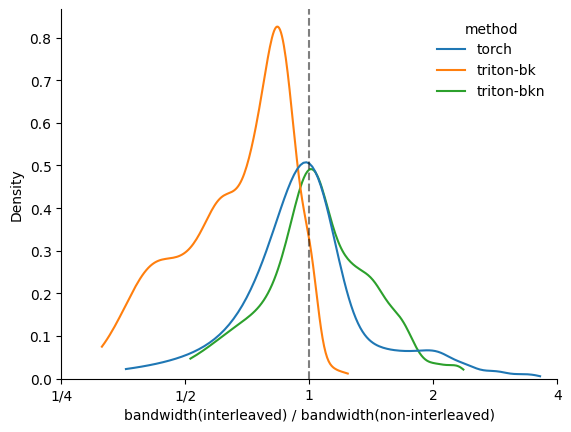

In [6]:
d = df.groupby(["topk_size", "topk_ratio", "method"]).apply(lambda g: g.bandwidth[g.interleaved].iloc[0] / g.bandwidth[~g.interleaved].iloc[0], include_groups=False).to_frame("interleaved_bandwidth_ratio").reset_index()
ax = sns.kdeplot(d, x="interleaved_bandwidth_ratio", hue="method", cut=0)
ax.set_xscale("log", base=2)
ax.set_xlabel("bandwidth(interleaved) / bandwidth(non-interleaved)")
ax.xaxis.set_major_formatter(lambda x, _: f"{x:.0f}" if x >= 1 else f"1/{1/x:.0f}")
ax.axvline(1, color="k", alpha=.5, ls="--")
ax.set_xlim((1/4, 4));

## Neither triton method improves, in general, over `torch.compile`

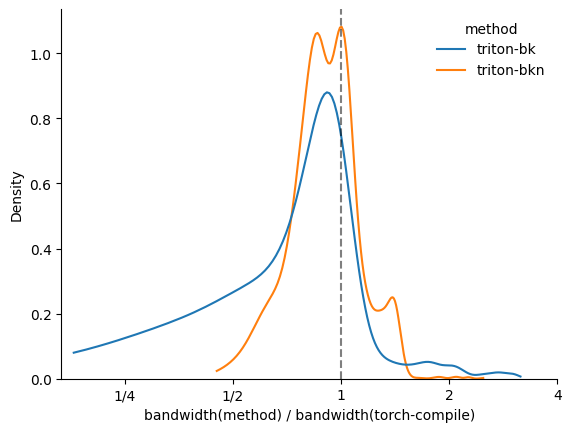

In [7]:
d = df.groupby(["topk_size", "topk_ratio", "interleaved"]).apply(lambda g: g.assign(bandwidth_vs_torch=g.bandwidth / g.bandwidth[g.method=="torch"].iloc[0]), include_groups=False).reset_index()
ax = sns.kdeplot(d[d.method!="torch"], x="bandwidth_vs_torch", hue="method", cut=0)
ax.set_xscale("log", base=2)
ax.set_xlabel("bandwidth(method) / bandwidth(torch-compile)")
ax.xaxis.set_major_formatter(lambda x, _: f"{x:.0f}" if x >= 1 else f"1/{1/x:.0f}")
ax.axvline(1, color="k", alpha=.5, ls="--")
ax.set_xlim((1/6, 4));